***PART 1 - LOADING LIBRARIES AND DATABASE***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

import warnings
warnings.filterwarnings('ignore')



In [2]:
pd.options.display.max_columns = None #The dataset is huge. To see all of the columns, we change max columns
pd.options.display.max_seq_items=1000
pd.options.display.max_rows=1000

In [3]:
fname1='https://drive.google.com/file/d/1XoqPujIOGHQStuAqM6Gzyqbkha4c5Y96/view?usp=sharing'
fname1='https://drive.google.com/uc?id=' + fname1.split('/')[-2]
dataset = pd.read_csv(fname1, low_memory=False)

In [4]:
dataset.shape

(5526, 58)

In [5]:
dataset.columns

Index(['Unnamed: 0', 'Permit Number', 'Permit Type', 'Permit Type Definition',
       'Permit Creation Date', 'Block', 'Lot', 'Street Number',
       'Street Number Suffix', 'Street Name', 'Street Suffix', 'Unit',
       'Unit Suffix', 'Description', 'Current Status', 'Current Status Date',
       'Filed Date', 'Issued Date', 'Completed Date',
       'First Construction Document Date', 'Structural Notification',
       'Number of Existing Stories', 'Number of Proposed Stories',
       'Voluntary Soft-Story Retrofit', 'Fire Only Permit',
       'Permit Expiration Date', 'Estimated Cost', 'Revised Cost',
       'Existing Use', 'Existing Units', 'Proposed Use', 'Proposed Units',
       'Plansets', 'TIDF Compliance', 'Existing Construction Type',
       'Existing Construction Type Description', 'Proposed Construction Type',
       'Proposed Construction Type Description', 'Site Permit',
       'Supervisor District', 'Neighborhoods - Analysis Boundaries', 'Zipcode',
       'Location', 'Reco

#DATA VISUALISATION

***Let's explore our dataset***

In [6]:
import seaborn as sns

In [7]:
cols = [#'Permit Type', 'Current Status',
        'Duration', 'Year',
        'Estimated Cost', 'Revised Cost',
        'Neighborhoods - Analysis Boundaries', 'Zipcode',
       'Number of Existing Stories', 'Number of Proposed Stories',
       #'Existing Use', 'Existing Units',
        'Proposed Use', 'Proposed Units',
       # 'Existing Construction Type','Existing Construction Type Description',
        'Proposed Construction Type','Proposed Construction Type Description',
        'Plansets'
       ]
dataset[cols].shape


(5526, 13)

In [43]:
"""comment on this figure
newdf=dataset[cols].sample(1000)#frac=0.01)#0.15)


fig, axes = plt.subplots(nrows = 10, ncols = 2)    # axes is 2d array (3x3)
axes = axes.flatten()         # Convert axes to 1d array of length 9
fig.set_size_inches(20, 40)

for ax, col in zip(axes, newdf.columns):
    sns.histplot(data=newdf,y=col,kde=True,ax=ax,stat='density',color='forestgreen')
    #if 'cost' in col.lower():
    #  sns.histplot(data=newdf,y=col,kde=True,ax=ax,stat='density',color='forestgreen',log_scale=True)
    #ax.set_title(col)
    #print(col)
#fig.savefig('drive/MyDrive/colab/data_exploration_.png',dpi=800)
#fig.close()
"""


"comment on this figure\nnewdf=dataset[cols].sample(1000)#frac=0.01)#0.15)\n\n\nfig, axes = plt.subplots(nrows = 10, ncols = 2)    # axes is 2d array (3x3)\naxes = axes.flatten()         # Convert axes to 1d array of length 9\nfig.set_size_inches(20, 40)\n\nfor ax, col in zip(axes, newdf.columns):\n    sns.histplot(data=newdf,y=col,kde=True,ax=ax,stat='density',color='forestgreen')\n    #if 'cost' in col.lower():\n    #  sns.histplot(data=newdf,y=col,kde=True,ax=ax,stat='density',color='forestgreen',log_scale=True)\n    #ax.set_title(col)\n    #print(col)\n#fig.savefig('drive/MyDrive/colab/data_exploration_.png',dpi=800)\n#fig.close()\n"

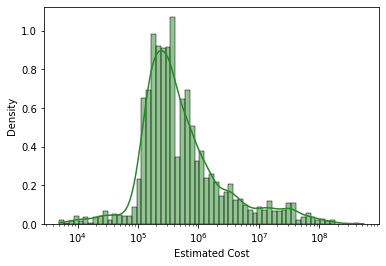

In [44]:
#histogram
sns.histplot(data= dataset , x='Estimated Cost',kde=True,stat='density',color='forestgreen',log_scale=True)

***Let's explore heatmap***

In [45]:
newdf = dataset[cols]

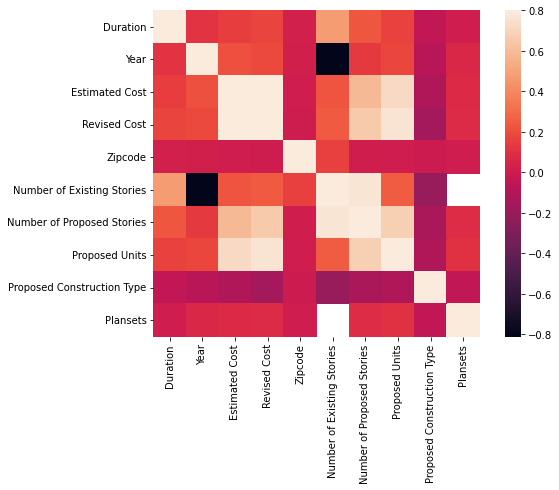

In [46]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(newdf.corr(), vmax=.8, square=True)
#fig.savefig('drive/MyDrive/colab/data_heatmap.jpg',dpi=400)

**Observations of HeatMap**



*   List item
*   List item



**In summary **

we can conclude that 



*   List item
*   List item



#MACHINE LEARNING



In [47]:
#kaggle ref. https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard


#libraries 

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler,OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error,r2_score
import xgboost as xgb
import lightgbm as lgb

In [48]:
# Separate target variable Y from features X
print("Separating labels from features...")
features_list = [
    "Permit Type",
    #"Unit",
    #"Street Name",
    "Number of Proposed Stories", 
    "Plansets", 
    "Proposed Construction Type", 
    "Neighborhoods - Analysis Boundaries", 
    #"Zipcode",
    "Year",
    "Duration"
]

target_variable = "Estimated Cost_log10"#"Estimated Cost"

X = dataset.loc[:,features_list]
Y = dataset.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())


Separating labels from features...
...Done.

Y : 
0    5.397940
1    7.653213
2    5.505150
3    5.243038
4    5.130212
Name: Estimated Cost_log10, dtype: float64

X :
   Permit Type  Number of Proposed Stories  Plansets  \
0            2                         4.0       2.0   
1            1                         5.0       4.0   
2            2                         4.0       2.0   
3            2                         3.0       2.0   
4            2                         3.0       2.0   

   Proposed Construction Type Neighborhoods - Analysis Boundaries  Year  \
0                           5                 Castro/Upper Market  1991   
1                           1                               Other  1991   
2                           5                               Other  1995   
3                           5                               Other  1995   
4                           5                               Other  1996   

   Duration  
0     815.0  
1    1100.0  
2 

In [49]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['Permit Type', 'Number of Proposed Stories', 'Plansets', 'Proposed Construction Type', 'Year', 'Duration']
Found categorical features  ['Neighborhoods - Analysis Boundaries']


In [50]:
#Manually selecting type of features
numeric_features=['Number of Proposed Stories', 'Duration']
categorical_features=['Plansets','Permit Type', 'Proposed Construction Type', 'Neighborhoods - Analysis Boundaries','Year'] #'Zipcode'

In [51]:
#Since we use Kfold, we don't divide data into train and test data set!
#for X_train and Y_train we use all dataset since we use K-fold
X_train = X
Y_train = Y 
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.0, random_state=0)#,stratify=Y)
print("...Done.")
print()

...Done.



In [52]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # missing values will be replaced by columns' mean
    ('scaler', StandardScaler())
])

In [53]:
# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

In [54]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [55]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
#print(X.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()

"""
# Preprocessings on test set 
# IT IS COMMENTED SINCE WE USE K FOLD 
print("Performing preprocessings on test set...")
print(X_test.head()) 
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('...Done.')
print(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()
"""

Performing preprocessings on train set...
...Done.
   Permit Type  Number of Proposed Stories  Plansets  \
0            2                         4.0       2.0   
1            1                         5.0       4.0   
2            2                         4.0       2.0   
3            2                         3.0       2.0   
4            2                         3.0       2.0   

   Proposed Construction Type Neighborhoods - Analysis Boundaries  Year  \
0                           5                 Castro/Upper Market  1991   
1                           1                               Other  1991   
2                           5                               Other  1995   
3                           5                               Other  1995   
4                           5                               Other  1996   

   Duration  
0     815.0  
1    1100.0  
2     528.0  
3     496.0  
4     662.0  



'\n# Preprocessings on test set \n# IT IS COMMENTED SINCE WE USE K FOLD \nprint("Performing preprocessings on test set...")\nprint(X_test.head()) \nX_test = preprocessor.transform(X_test) # Don\'t fit again !! The test set is used for validating decisions\n# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.\n# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.\nprint(\'...Done.\')\nprint(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore\nprint()\n'

In [56]:
np.isnan(Y_train).sum()

0

#***---CROSS VALIDATION---***


We take the cross_val_score function of Sklearn. Then, we use the function Kfold where shuffle = True to allow a shuffle attribution as cross_val_score does not have this option.

***Define Metrics as Function Below***




In [71]:
#Validation function
n_folds = 3

#sqrt of negative mean error
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=0).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, Y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [72]:
#R2

def R2_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=0).get_n_splits(X_train)
    R2= cross_val_score(model, X_train, Y_train, scoring="r2", cv = kf)
    return(R2)


***Definiton of base models***

***Linear Regression :***
    

Not that we dont apply Robustscaler()! It can be useful to make data more robust on outliers in the future. We can use sklearn's Robustscaler() method on pipeline


In [73]:
regressor0= LinearRegression()

***LASSO Regression :***
    



In [74]:
lasso = Lasso(alpha =0.0005, random_state=0)
#make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

***Elastic Net Regression :***




In [75]:
ENet = ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=0)
#make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

Kernel Ridge Regression :

In [76]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

***Gradient Boosting Regression :***


With huber loss, our model is more robust to outliers


In [77]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =0)

***XGBoost :***

In [78]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =0, nthread = -1)

**LightGBM - Gradient Boosting With LightGBM**

LightGBM is an algorithm developed by Microsoft in 2017. It has an advantage of changing the training algorithm that make the run time faster and likely result in a more effective model.

Ref. to the LightGBM algorithm paper:

    LightGBM: A Highly Efficient Gradient Boosting Decision Tree, 2017.
link : https://papers.nips.cc/paper/2017/hash/6449f44a102fde848669bdd9eb6b76fa-Abstract.html

In [79]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)


#Base models scores

Let's see how these base models perform on the data by evaluating the cross-validation metrics


In [80]:
model = regressor0
print("\nLinear regressor model\n")
score_1 = R2_cv(model)
print("R2 score - mean : {:.4f}  |  std : {:.4f}\n".format(score_1.mean(), score_1.std()))
score_2 = rmsle_cv(model)
print("\nRMSLE regressor score - mean : {:.4f}  |  std : {:.4f}\n".format(score_2.mean(), score_2.std()))


Linear regressor model

R2 score - mean : 0.3670  |  std : 0.1367


RMSLE regressor score - mean : 0.5193  |  std : 0.1325



In [81]:
model = lasso

print("\nLasso model\n")
score_1 = R2_cv(model)
print("R2 score - mean : {:.4f}  |  std : {:.4f}\n".format(score_1.mean(), score_1.std()))
score_2 = rmsle_cv(model)
print("\nRMSLE regressor score - mean : {:.4f}  |  std : {:.4f}\n".format(score_2.mean(), score_2.std()))


Lasso model

R2 score - mean : 0.3418  |  std : 0.0878


RMSLE regressor score - mean : 0.5261  |  std : 0.1016



In [82]:
model = ENet
print("\nElastic Net regressor model\n")
score_1 = R2_cv(model)
print("R2 score - mean : {:.4f}  |  std : {:.4f}\n".format(score_1.mean(), score_1.std()))
score_2 = rmsle_cv(model)
print("\nRMSLE regressor score - mean : {:.4f}  |  std : {:.4f}\n".format(score_2.mean(), score_2.std()))



Elastic Net regressor model

R2 score - mean : 0.3429  |  std : 0.0910


RMSLE regressor score - mean : 0.5259  |  std : 0.1041



In [83]:
model = KRR
print("\nKernel Ridge model\n")
score_1 = R2_cv(model)
print("R2 score - mean : {:.4f}  |  std : {:.4f}\n".format(score_1.mean(), score_1.std()))
score_2 = rmsle_cv(model)
print("\nRMSLE regressor score - mean : {:.4f}  |  std : {:.4f}\n".format(score_2.mean(), score_2.std()))


Kernel Ridge model

R2 score - mean : 0.4033  |  std : 0.0788


RMSLE regressor score - mean : 0.5006  |  std : 0.0950



In [84]:
model = GBoost
print("\nGradient Boosting model\n")
score_1 = R2_cv(model)
print("R2 score - mean : {:.4f}  |  std : {:.4f}\n".format(score_1.mean(), score_1.std()))
score_2 = rmsle_cv(model)
print("\nRMSLE regressor score - mean : {:.4f}  |  std : {:.4f}\n".format(score_2.mean(), score_2.std()))



Gradient Boosting model

R2 score - mean : 0.5470  |  std : 0.0176


RMSLE regressor score - mean : 0.4364  |  std : 0.0715



In [85]:
model = model_xgb
print("\n XGBoost model\n")
score_1 = R2_cv(model)
print("R2 score - mean : {:.4f}  |  std : {:.4f}\n".format(score_1.mean(), score_1.std()))
score_2 = rmsle_cv(model)
print("\nRMSLE regressor score - mean : {:.4f}  |  std : {:.4f}\n".format(score_2.mean(), score_2.std()))


 XGBoost model

R2 score - mean : 0.5529  |  std : 0.0344


RMSLE regressor score - mean : 0.4345  |  std : 0.0803



In [86]:
model = model_lgb
print("\nLGBM model\n")
score_1 = R2_cv(model)
print("R2 score - mean : {:.4f}  |  std : {:.4f}\n".format(score_1.mean(), score_1.std()))
score_2 = rmsle_cv(model)

print("\nRMSLE regressor score - mean : {:.4f}  |  std : {:.4f}\n".format(score_2.mean(), score_2.std()))


LGBM model

R2 score - mean : 0.5391  |  std : 0.0337


RMSLE regressor score - mean : 0.4382  |  std : 0.0610



Stopped here 11/08/22

***Add your observations and conclusions here***



*** SUMMARY ***

Metric 1 :

Metric 2 :




*** Conclusion : ***



Comment on your results

Which metric to use ?
